In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import kruskal, mannwhitneyu
import itertools
from statsmodels.stats.multitest import multipletests
from mpl_toolkits.mplot3d import Axes3D
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.stats import linregress

In [14]:
data_path_downstream = '/project2/kribelba_1515/saadawy/mpra/downstream/agg_sum_norm_FALSE_model_indep_groups.csv'
data_path_upstream = '/project2/kribelba_1515/saadawy/mpra/upstream/agg_sum_norm_FALSE_model_indep_groups.csv'
enhancer_barcode_counts_downstream = pd.read_csv('/project2/kribelba_1515/saadawy/enhancer_barcode_count_downstream.tsv',sep='\t')
enhancer_barcode_counts_upstream = pd.read_csv('/project2/kribelba_1515/saadawy/enhancer_barcode_count_upstream.tsv',sep='\t')
df_downstream = pd.read_csv(data_path_downstream, sep=',', usecols=['logFC', 'SE', 'uid']).rename(columns={'uid': 'Enhancer'})
df_upstream = pd.read_csv(data_path_upstream, sep=',', usecols=['logFC', 'SE', 'uid']).rename(columns={'uid': 'Enhancer'})
merged_enhancer_barcode_counts = pd.merge(enhancer_barcode_counts_upstream, enhancer_barcode_counts_downstream, on="Enhancer", suffixes=('_TSS_upstream', '_TSS_downstream'))

In [15]:
intersected_enhancers = (set(df_downstream['Enhancer']) & set(df_upstream['Enhancer']))
df_downstream = df_downstream[df_downstream['Enhancer'].isin(intersected_enhancers)]
df_upstream = df_upstream[df_upstream['Enhancer'].isin(intersected_enhancers)]

In [17]:
merged_df = pd.merge(df_upstream, df_downstream, on="Enhancer", suffixes=('_TSS_upstream', '_TSS_downstream'))
merged_df = merged_df[[c for c in merged_df.columns if c != 'Enhancer'] + ['Enhancer']]
# --- Normalization using rd ---
reference = merged_df[merged_df['Enhancer'] == 'rd'].iloc[0]

merged_df_rd_normalized = merged_df.copy()
for col in ['logFC_TSS_downstream', 'logFC_TSS_upstream']:
    merged_df_rd_normalized[col] = merged_df[col] - reference[col]

In [18]:
logfc_cols = {
    "TSS_downstream": merged_df_rd_normalized["logFC_TSS_downstream"],
    "TSS_upstream": merged_df_rd_normalized["logFC_TSS_upstream"]
}

pairwise_results = []
raw_pvalues = []

for (cond1, vals1), (cond2, vals2) in itertools.combinations(logfc_cols.items(), 2):
    stat, p = mannwhitneyu(vals1, vals2, alternative='two-sided')
    pairwise_results.append({
        "Comparison": f"{cond1} vs {cond2}",
        "U-Statistic": stat,
        "P-value": p
    })
    raw_pvalues.append(p)


pairwise_df = pd.DataFrame(pairwise_results)
pairwise_df

,Comparison,U-Statistic,P-value
0,TSS_downstream vs TSS_upstream,918.5,5.093299e-40


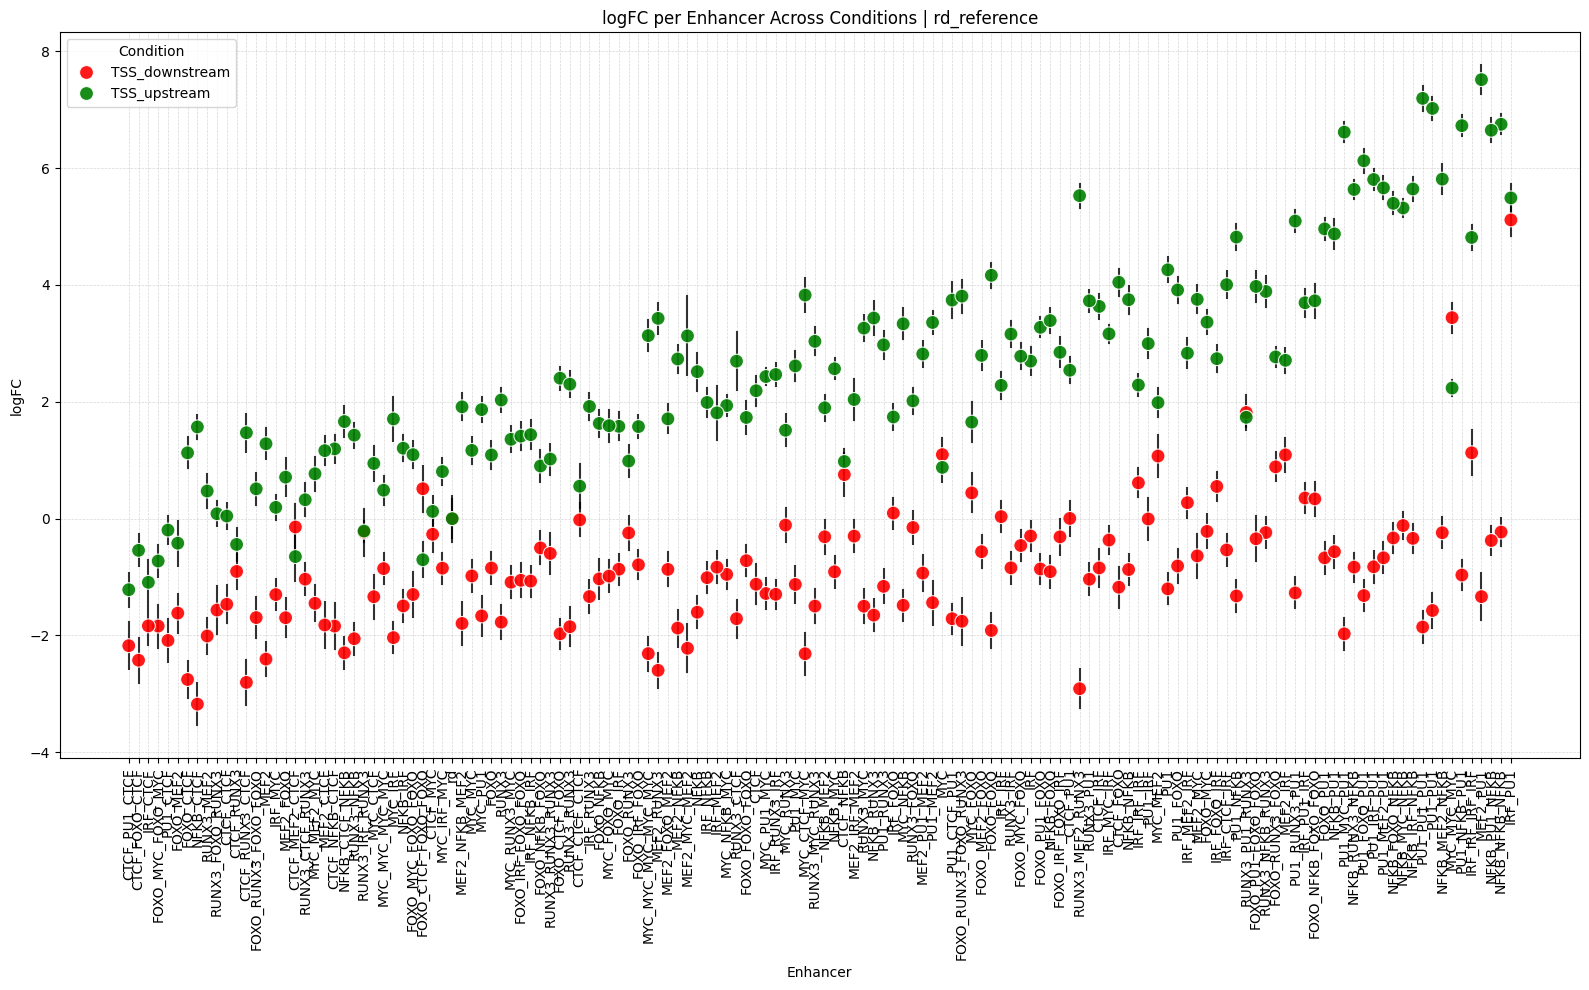

In [19]:
logfc_long = pd.melt(
    merged_df_rd_normalized,
    id_vars=["Enhancer"],
    value_vars=["logFC_TSS_downstream", "logFC_TSS_upstream"],
    var_name="Condition",
    value_name="logFC"
)

se_long = pd.melt(
    merged_df_rd_normalized,
    id_vars=["Enhancer"],
    value_vars=["SE_TSS_downstream", "SE_TSS_upstream"],
    var_name="Condition",
    value_name="SE"
)

long_df = logfc_long.copy()
long_df["SE"] = se_long["SE"]

long_df["Condition"] = long_df["Condition"].str.replace("logFC_", "").str.replace("SE_", "")

palette = {
    "TSS_downstream": "red",
    "TSS_upstream": "green"
}

enhancer_order = long_df.groupby("Enhancer")["logFC"].mean().sort_values().index.tolist()
long_df["Enhancer"] = pd.Categorical(long_df["Enhancer"], categories=enhancer_order, ordered=True)

plt.figure(figsize=(16, 10))
sns.scatterplot(
    data=long_df,
    x="Enhancer",
    y="logFC",
    hue="Condition",
    palette=palette,
    s=100,
    alpha=0.9,
    zorder=3
)

for _, row in long_df.iterrows():
    plt.plot(
        [row["Enhancer"], row["Enhancer"]],
        [row["logFC"] - row["SE"], row["logFC"] + row["SE"]],
        color="black",
        linewidth=1.5,
        alpha=0.8,
        zorder=2
    )

plt.xticks(rotation=90)
plt.xlabel("Enhancer")
plt.ylabel("logFC")
plt.title("logFC per Enhancer Across Conditions | rd_reference")
plt.legend(title="Condition")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.show()
# plt.savefig('logFC_enhancer.png', dpi=600)

/tmp/SLURM_267415/ipykernel_1687750/2396366494.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Condition', y='logFC', data=melted, palette=["skyblue", "lightgreen"])


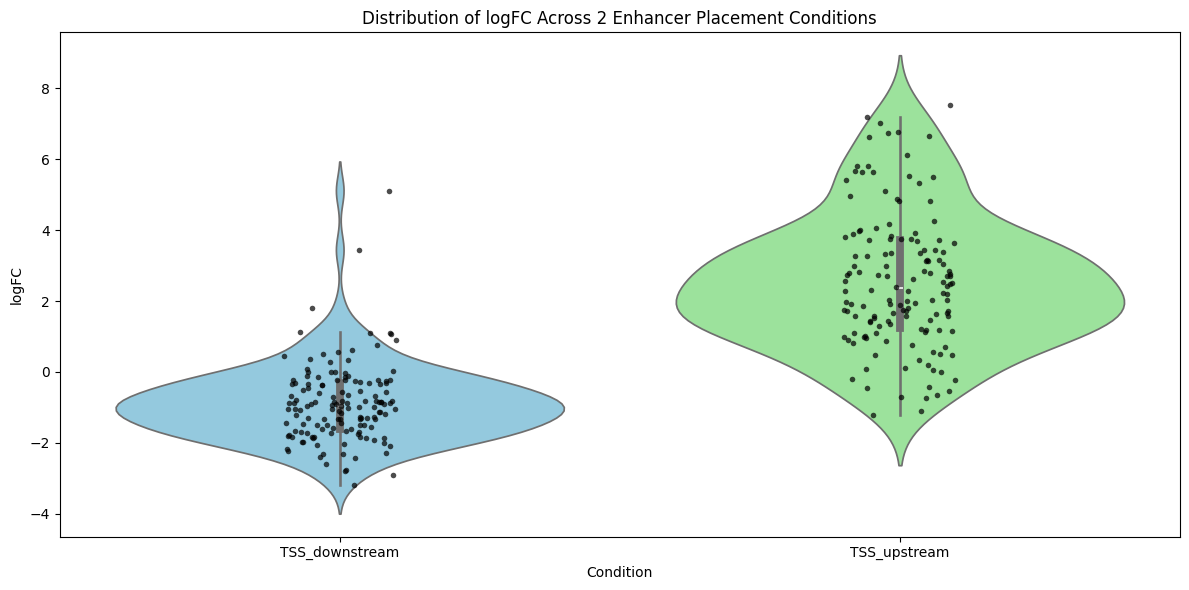

In [20]:
melted = pd.melt(
    merged_df_rd_normalized[['Enhancer', 'logFC_TSS_downstream', 'logFC_TSS_upstream']],
    id_vars='Enhancer',
    var_name='Condition',
    value_name='logFC'
)

melted['Condition'] = melted['Condition'].str.replace('logFC_', '')

plt.figure(figsize=(12, 6))
sns.violinplot(x='Condition', y='logFC', data=melted, palette=["skyblue", "lightgreen"])
sns.stripplot(x='Condition', y='logFC', data=melted, color='black', size=4, jitter=True, alpha=0.7)

plt.title("Distribution of logFC Across 2 Enhancer Placement Conditions")
plt.ylabel("logFC")
plt.tight_layout()
plt.show()

/tmp/SLURM_267415/ipykernel_1687750/1071242947.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logfc_data['average_logFC'] = logfc_data.mean(axis=1)


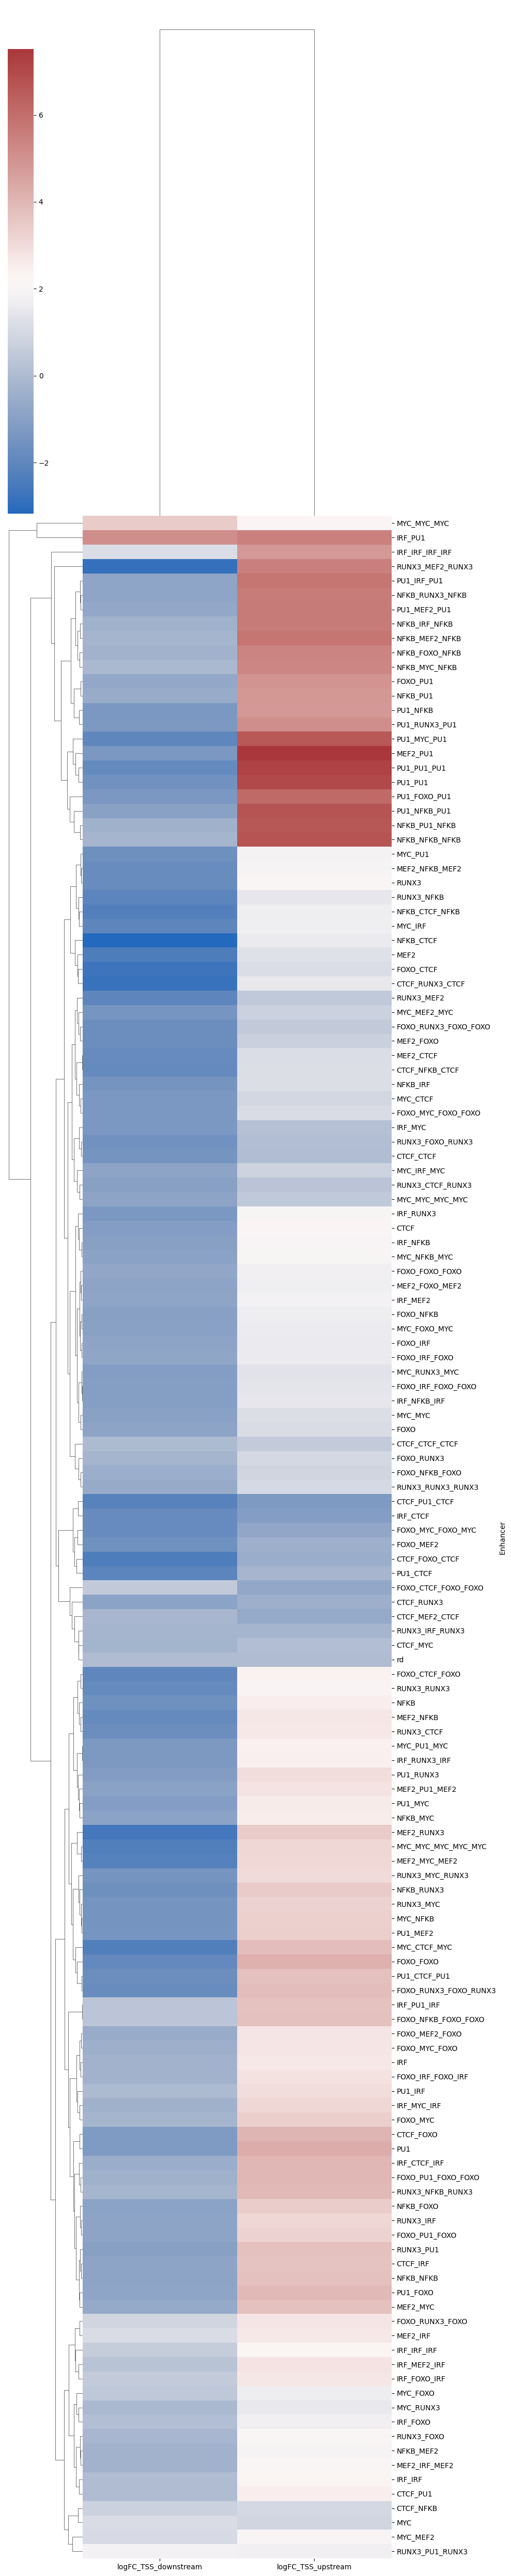

In [23]:
logfc_data = merged_df_rd_normalized[[
    "logFC_TSS_downstream", "logFC_TSS_upstream"
]]
logfc_data.index = merged_df_rd_normalized["Enhancer"]

logfc_data['average_logFC'] = logfc_data.mean(axis=1)
logfc_data = logfc_data.sort_values('average_logFC', ascending=True).drop('average_logFC', axis=1)


sns.clustermap(logfc_data, cmap="vlag", figsize=(10, 50))
# plt.savefig("logFC_clustermap.png", dpi=600, bbox_inches='tight')

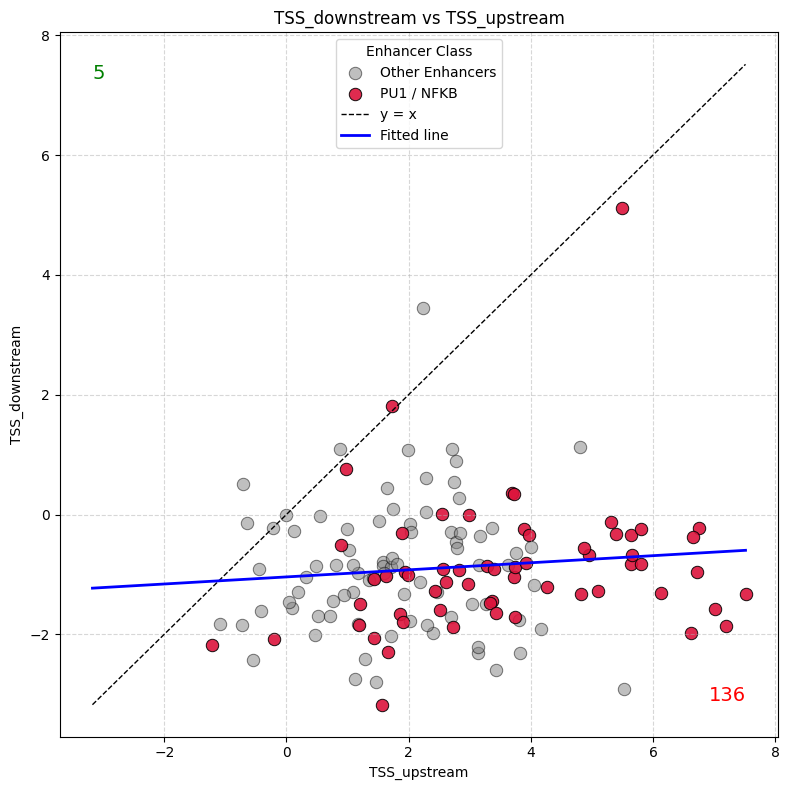

In [26]:
subset_df = merged_df_rd_normalized[
    ["Enhancer", "logFC_TSS_downstream", "logFC_TSS_upstream"]
].copy()

motif_pattern = "PU1|NFKB"
subset_df["Motif_Group"] = subset_df["Enhancer"].str.contains(motif_pattern, regex=True)

pairs = [
    ("logFC_TSS_upstream", "logFC_TSS_downstream"),
]

for x_col, y_col in pairs:
    plt.figure(figsize=(8, 8))

    sns.scatterplot(
        data=subset_df[~subset_df["Motif_Group"]],
        x=x_col,
        y=y_col,
        color="gray",
        label="Other Enhancers",
        edgecolor="black",
        s=80,
        alpha=0.5
    )

    sns.scatterplot(
        data=subset_df[subset_df["Motif_Group"]],
        x=x_col,
        y=y_col,
        color="crimson",
        label="PU1 / NFKB",
        edgecolor="black",
        s=80,
        alpha=0.9
    )

    lims = [
        np.min([subset_df[x_col].min(), subset_df[y_col].min()]),
        np.max([subset_df[x_col].max(), subset_df[y_col].max()])
    ]
    plt.plot(lims, lims, 'k--', linewidth=1, label='y = x')

    slope, intercept, r_value, p_value, std_err = linregress(subset_df[x_col], subset_df[y_col])
    reg_x = np.array(lims)
    reg_y = intercept + slope * reg_x
    plt.plot(reg_x, reg_y, color='blue', linewidth=2, label=f'Fitted line')

    count_above = (subset_df[y_col] > subset_df[x_col]).sum()
    count_below = (subset_df[y_col] < subset_df[x_col]).sum()

    plt.text(lims[0], lims[1], f"{count_above}", ha='left', va='top', fontsize=14, color='green')
    plt.text(lims[1], lims[0], f"{count_below}", ha='right', va='bottom', fontsize=14, color='red')

    plt.xlabel(x_col.replace("logFC_", ""))
    plt.ylabel(y_col.replace("logFC_", ""))
    plt.title(f"{y_col.replace('logFC_', '')} vs {x_col.replace('logFC_', '')}")
    plt.legend(title="Enhancer Class", loc='upper center')
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()